### 목표 : 미니배치기반 기계학습 진행 실습
- 확률적경사하강법 기반의 알고리즘 적용 모델
- 데이터의 처음부터 끝까지(에포크) 학습 후 가중치(W)와 절편(b) 업데이트 하는 방식에서 에포크를 미니배치 크기만큼 나누어서 학습 후 가중치(W)와 절편(b) 업데이트 진행 함
- 장점
    * 온라인 학습 즉, 점진적 학습 가능 => partial_fit() : 기존 모델에 추가로 1에포크 학습
    * 기존의 다른 모델보다 속도 빠름 => 랜덤으로 한개 데이터 추출 후 학습 진행
    * 조기 학습 중단 설정 가능
- 단점
    * 전체 학습보다 정확도는 떨어질 수 있음!

[1] 모듈 로딩 및 데이터 준비 <hr>

In [446]:
# 모듈 로딩
import pandas as pd

data = '../data/fish.csv'

In [447]:
# 데이터 로딩
fishDF=pd.read_csv(data)
fishDF

,Species,Weight,Length,Diagonal,Height,Width
0,Bream,242.0,25.4,30.0,11.5200,4.0200
1,Bream,290.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,26.5,31.1,12.3778,4.6961
3,Bream,363.0,29.0,33.5,12.7300,4.4555
4,Bream,430.0,29.0,34.0,12.4440,5.1340
...,...,...,...,...,...,...
154,Smelt,12.2,12.2,13.4,2.0904,1.3936
155,Smelt,13.4,12.4,13.5,2.4300,1.2690
156,Smelt,12.2,13.0,13.8,2.2770,1.2558
157,Smelt,19.7,14.3,15.2,2.8728,2.0672


[2] 데이터 전처리 => 학습을 위한 가공 <hr>

[2-1] 피쳐 / 타겟 분리

In [448]:
featureDF=fishDF[fishDF.columns[1:]]
targetDF=fishDF['Species']

print(f'피쳐 => {featureDF.shape}, 타겟 => {targetDF.shape}')

피쳐 => (159, 5), 타겟 => (159,)


[2-2] 학습/테스트용 데이터셋 분리

In [449]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(featureDF, 
                                                    targetDF, 
                                                    stratify=targetDF,
                                                   random_state=41)

In [450]:
print(f'[훈련용] => {x_train.shape},  {y_train.shape}')
print(f'[테스트용] => {x_test.shape},  {y_test.shape}')

[훈련용] => (119, 5),  (119,)
[테스트용] => (40, 5),  (40,)


[2-3] 피쳐 => 스케일링

In [451]:
# 피쳐 스케일러
from sklearn.preprocessing import StandardScaler

sdScaler = StandardScaler()
sdScaler.fit(x_train)

StandardScaler()

In [452]:
# 훈련용 데이터셋 스케일링
scaled_x_train=sdScaler.transform(x_train)

# 테스트용 데이터셋 스케일링
scaled_x_test = sdScaler.transform(x_test)

[3] 학습 진행 <hr>
- 학습 방법 : 확률적경사하강법(SGD)기반의 분류

In [453]:
# 모델 인스턴스 생성
from sklearn.linear_model import SGDClassifier

model1 = SGDClassifier(random_state=41, verbose=0, loss='log_loss', alpha=0.1) # alpha(강도조절): 과대적합을 방지하기 위해 규제의 강도를 조절함, 값이 ↓ 규제가 약해지고, ↑ 규제가 강해짐
model1.fit(scaled_x_train, y_train)

SGDClassifier(alpha=0.1, loss='log_loss', random_state=41)

In [454]:
train_score1 = model1.score(scaled_x_train, y_train)
test_score1 = model1.score(scaled_x_test, y_test)

In [455]:
print(f'[기본 SGD] 학습 점수 : {train_score1}, 테스트 점수 : {test_score1}')

[기본 SGD] 학습 점수 : 0.6974789915966386, 테스트 점수 : 0.725


In [456]:
# 학습 후 설정된 파라미터 즉 모델 파라미터
print(f'n_iter_ : {model1.n_iter_}')

n_iter_ : 14


- 1에포크씩 점진적으로 학습 진행 => partial_fit()

In [457]:
# 모델 인스턴스 생성

model2 = SGDClassifier(loss='log_loss')
model2.partial_fit(scaled_x_train, y_train, y_train.unique())

SGDClassifier(loss='log_loss')

In [458]:
train_score2 = model2.score(scaled_x_train, y_train)
test_score2 = model2.score(scaled_x_test, y_test)

In [459]:
print(f'[기본 SGD] 학습 점수 : {train_score2}, 테스트 점수 : {test_score2}')

[기본 SGD] 학습 점수 : 0.6218487394957983, 테스트 점수 : 0.65


In [460]:
train_score, test_score = [], []
for n in range(1, 100):
    model2.partial_fit(scaled_x_train, y_train, y_train.unique())
    train_score2 = model2.score(scaled_x_train, y_train)
    test_score2 = model2.score(scaled_x_test, y_test)
    #print(f'[{n}번 학습] [기본 SGD] 학습 점수 : {train_score2}, 테스트 점수 : {test_score2}')
    train_score.append(train_score2)
    test_score.append(test_score2)
    if (test_score2>=0.90) and (abs(test_score2 - train_score2) >= 0.01):
        break;
        
print(f'n => {n}')

n => 44


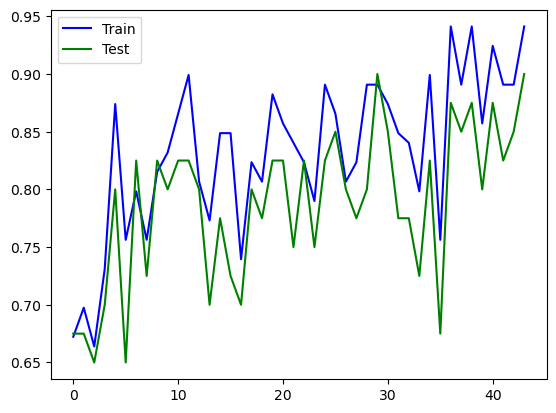

In [461]:
# 시각화
import matplotlib.pyplot as plt

plt.plot(train_score, 'b-', label='Train')
plt.plot(test_score, 'g-', label='Test')
plt.legend()
plt.show()